# Lab 4 - Ensemble methods
### Analysis of the data set [accidents de voiture en 2021](https://www.data.gouv.fr/fr/datasets/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2021/) on *data.gouv.fr*

We are going to work on three files resulting from a small cleaning of the car accident database for 2021.

carac_accidents_2021.csv : accidents data   
vehicules_2021.csv : vehicle data   
usagers_2021.csv : victims data

The aim is first to perform some exploratory data analysis (EDA), and then to predict the severity of an accident, based on features (type of vehicle, luminosity, speed, etc.)

You should provide answers to the questions marked with the symbol ⏩

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk
import seaborn as sns

In [28]:
filename = 'accident'

from urllib.request import urlretrieve
urlretrieve("https://bianchi.wp.imt.fr/files/2023/12/accident.zip", filename + '.zip')

import os
zip_file = os.path.join(os.getcwd(), filename + '.zip')

import zipfile
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(os.getcwd())

## Loading Data, Merging into a Single DataFrame, and Cleanups

In [29]:
carac=pd.read_csv("carac_accidents_2021.csv")
carac.tail()

,Num_Acc,jour,mois,an,hrmn,lum,dep,agg,int,atm,col,lat,long,catr,circ,nbv,prof,surf,vma
56513,202100056514,1,1,2021,06:10,3,33,1,1,5,6,"44,5266190000","-0,1955440000",1,3,4,2,2,130
56514,202100056515,1,1,2021,10:20,1,38,1,1,2,6,"45,3802910000","5,7049140000",3,2,2,1,5,80
56515,202100056516,1,1,2021,18:00,3,26,1,1,2,1,"44,9112100000","5,0196360000",3,2,2,2,2,80
56516,202100056517,1,1,2021,10:55,1,33,1,2,1,6,"44,9542747363","-0,5179211363",4,2,2,1,2,80
56517,202100056518,2,1,2021,18:00,3,78,1,1,3,1,"48,7966700000","2,0505000000",3,2,2,1,2,70


In [30]:
vhc=pd.read_csv("vehicules_2021.csv")
vhc.tail()

,Num_Acc,id_vehicule,catv,obs,obsm,motor,occutc
97310,202100056516,100 885,7,0,2,1,NaN
97311,202100056516,100 886,7,0,2,1,NaN
97312,202100056517,100 884,7,6,0,1,NaN
97313,202100056518,100 882,7,0,2,1,NaN
97314,202100056518,100 883,7,0,2,1,NaN


In [31]:
usag=pd.read_csv("usagers_2021.csv")
usag.tail()

,Num_Acc,id_vehicule,place,catu,grav,sexe,an_nais,trajet,secu1,secu2,secu3,locp,actp,etatp
129148,202100056516,100 885,1,1,4,1,1975.0,0,1,-1,-1,0,0,-1
129149,202100056516,100 886,1,1,4,1,2002.0,5,1,-1,-1,0,0,-1
129150,202100056517,100 884,1,1,3,1,1999.0,0,0,-1,-1,0,0,-1
129151,202100056518,100 882,1,1,3,1,1968.0,3,1,0,-1,-1,-1,-1
129152,202100056518,100 883,1,1,3,1,1985.0,3,1,0,-1,-1,-1,-1


### Meanings of the different fields in the three data files

#### In *carac_accidents_2021.csv*

Num_Acc: Identification number of the accident. The same in the other DataFrames

day, month, year: day of the accident, month of the accident, year of the accident.

hrmn: hour and minute of the accident.

lum: light, lighting conditions in which the accident occurred:

   1 – Full day

   2 – Dusk or dawn

   3 – Night without public lighting

   4 – Night with public lighting not on

   5 – Night with public lighting on

dep Department: INSEE code (National Institute of Statistics and Economic Studies) of department (2A Corse-du-Sud – 2B Haute-Corse).

agg: location:

   1 – Outside agglomeration

   2 – In built-up areas

int: intersection:

   1 – Out of intersection

   2 – X intersection

   3 – T-junction

   4 – Y intersection

   5 – Intersection with more than 4 branches

   6 – Roundabout

   7 – Square

   8 – Level crossing

   9 – Other intersection


atm: atmospheric conditions:

  -1 – Not filled in

   1 – Normal

   2 – Light rain

   3 – Heavy rain

   4 – Snow - hail

   5 – Fog - smoke

   6 – Strong wind - storm

   7 – Dazzling Time

   8 – Overcast weather

   9 – Other


col: type of collision:

  -1 – Not filled in

   1 – Two vehicles - frontal

   2 – Two vehicles – from behind

   3 – Two vehicles – from the side

   4 – Three or more vehicles – in a chain

   5 – Three or more vehicles - multiple collisions

   6 – Other Collision

   7 – Collision free


lat : latitude

Length: longitude

catr: road category:

   1 – Motorway

   2 – National road

   3 – Departmental Road

   4 – Communal roads

   5 – Outside the public network

   6 – Car park open to public traffic

   7 – Urban Metropolis Routes

   9 – other



circ: circulation regime:

  -1 – Not filled in

   1 – One way

   2 – Bidirectional

   3 – With separate carriageways

   4 – With variable assignment channels

nbv: total number of traffic lanes.

prof: longitudinal profile, describes the slope of the road at the place of the accident:

  -1 – Not filled in

   1 – Flat

   2 – Slope

   3 – Top of the hill

   4 – Bottom of the coast


surf: surface condition:

  -1 – Not filled in

   1 – Normal

   2 – Wet

   3 – Puddles

   4 – Flooded

   5 – Snowy

   6 – Mud

   7 – Icy

   8 – Fats – oil

   9 – Other

vma

Maximum authorized speed at the place and at the time of the accident.


#### In *vehicles_2021.csv*

Num_Acc: identifier of the accident identical to that of the "carac_accidents_2021" file included for each of the described vehicles involved in the accident.

id_vehicule: vehicle identifier

catv: vehicle category:

   00 – Indeterminable

   01 – Bicycle

   02 – Moped <50cm3

   03 – Cart (Quadricycle with bodied motor) (formerly "cart or motor tricycle")

   04 – Reference unused since 2006 (registered scooter)

   05 – Unused reference since 2006 (motorcycle)

   06 – Reference unused since 2006 (sidecar)

   07 – LV only

   08 – Reference unused since 2006 (VL + caravan)

   09 – Reference unused since 2006 (VL + trailer)

   10 – LCV only 1.5T <= GVW <= 3.5T with or without trailer (formerly LCV only 1.5T <= GVW       <= 3.5T)

   11 – Reference unused since 2006 (VU (10) + caravan)

   12 – Reference unused since 2006 (VU (10) + trailer)

   13 – PL only 3.5T <PTCA <= 7.5T

   14 – PL only > 7.5T

   15 – HGV > 3.5T + trailer

   16 – Road tractor only

   17 – Road tractor + semi-trailer

   18 – Reference unused since 2006 (public transport)

   19 – Reference unused since 2006 (tramway)

   20 – Special gear

   21 – Agricultural tractor

   30 – Scooter < 50 cc

   31 – Motorcycle > 50 cm3 and <= 125 cm3

   32 – Scooter > 50 cm3 and <= 125 cm3

   33 – Motorcycle > 125 cm3

   34 – Scooter > 125 cc

   35 – Light quad <= 50 cc (Unbodied motor quadricycle)

   36 – Heavy quad > 50 cm3 (Quadricycle with motor without bodywork)

   37 – Buses

   38 – Bus

   39 – Train

   40 – Tramway

   41 – 3WD <= 50cc

   42 – 3WD > 50cc <= 125cc

   43 – 3WD > 125 cc

   50 – Motor EDP

   60 – EDP without engine

   80 – eBike

   99 – Other vehicle



obs: fixed obstacle struck:

  -1 – Not filled in

   0 – Not applicable

   1 – Parked vehicle

   2 – Tree

   3 – Metal slider

   4 – Concrete slide

   5 – Other slide

   6 – Building, wall, bridge pier

   7 – Vertical signaling support or emergency call station

   8 – Pole

   9 – Street furniture

  10 – Parapet

  11 – Island, refuge, high boundary

  12 – Sidewalk curb

  13 – Ditch, embankment, rock face

  14 – Other fixed obstacle on roadway

  15 – Other fixed obstacle on sidewalk or shoulder

  16 – Obstacle-free road exit

  17 – Nozzle – aqueduct head


motor: type of vehicle engine:

  -1 – Not filled in

   0 – Unknown

   1 – Hydrocarbons

   2 – Electric hybrid

   3 – Electrical

   4 – Hydrogen

   5 – Human

   6 – Other

occutc: number of occupants in public transport.


#### In *users_2021.csv*

Num_Acc and id_vehicule: the same as in the previous file.

seat: allows you to locate the seat occupied in the vehicle by the user at the time of the accident, see the file
         "description ... pdf"

catu: user category:

   1 – Driver

   2 – Passenger

   3 – Pedestrian



**severity: severity of user injury, injured users are classified into three categories of
        victims plus uninjured:**

   1 – Free

   2 – Killed

   3 – Wounded hospitalized

   4 – Slightly injured

**Our classification algorithm will estimate the severity of the accident.**


gender: gender of user:

   1 – Male

   2 – Feminine


An_nais: year of birth of the user.

journey: reason for travel at the time of the accident:

  -1 – Not filled in

   0 – Not filled in

   1 – Home – work

   2 – Home – school

   3 – Shopping – purchases

   4 – Professional use

   5 – Walk – leisure

   9 – Other


From 2019, this is the use with up to 3 possible equipment for the same user
(especially for motorcyclists whose helmet and gloves are compulsory).

secu1, secu2, secu3: the information of the character indicates the presence and the use of the equipment of
    security :

  -1 – Not filled in

   0 – No equipment

   1 – Belt

   2 – Helmet

   3 – Children device

   4 – Reflective vest

   5 – Airbag (2WD/3WD)

   6 – Gloves (2WD/3WD)

   7 – Gloves + Airbag (2WD/3WD)

   8 – Not determinable

   9 – Other

locp: location of the pedestrian:

  -1 – Not filled in

   0 – Not applicable

  On pavement:

   1 – More than 50 m from the pedestrian crossing

   2 – Less than 50 m from the pedestrian crossing

  On pedestrian crossing:

   3 – Without light signaling

   4 – With light signaling

  Various :

   5 – On sidewalk

   6 – On shoulder

   7 – On refuge or emergency lane

   8 – On counter aisle

   9 – Unknown


actp pedestrian action:

   -1 – Not filled in

  Moving

    0 – Not filled in or not applicable

    1 – Direction of vehicle hitting

    2 – Reverse direction of the vehicle

  Various

    3 – Crossing

    4 – Hidden

    5 – Playing – running

    6 – With animal

    9 – Other

    A – Getting in/out of the vehicle

    B – Unknown

etatp: this variable is used to specify whether the injured pedestrian was alone or not:

   -1 – Not filled in

    1 – Alone

    2 – Accompanied

    3 – In a group



We find that there were 56,518 accidents in 2021 which involved 97,315 vehicles and 129,153 people.

Remember that Num_Acc, the identifier of the accident, is a column common to the three DataFrames. To an accident number corresponds a single line in charac and in general several lines in the two other DataFrames because an accident involves more than one vehicle and more than one person in general. You can check this, for example with the unique() and nunique() methods, or with value_counts()

In [32]:
print('Min and max number of vehicles per accident : ',min(vhc['Num_Acc'].value_counts()), max(vhc['Num_Acc'].value_counts()))
print('Min and max number of users per accident : ', min(usag['Num_Acc'].value_counts()),  max(usag['Num_Acc'].value_counts()))

Min and max number of vehicles per accident :  1 20
Min and max number of users per accident :  1 24


We will now create a large DF that groups all the data. To an entry in DF usag corresponds one or more entries in DF vhc, and to an entry in vhc corresponds one or more entries in DF carac.

The large DF will therefore have the dimensions of the used DF.

The merge() method documented [here](https://pandas.pydata.org/docs/reference/api/pandas.merge.html) and [there](https://realpython.com/pandas-merge-join -and-concat/) is made to achieve this type of merge

For illustration, here is a basic example of using merge()

In [33]:
df1 = pd.DataFrame({'key': ['aa', 'bb', 'ba', 'aa', 'tt'],'value': [1, 2, 3, 5, 10]})
df2 = pd.DataFrame({'key': ['aa', 'bb', 'ba', 'tu', 'bb'],'value': [5, 6, 7, 20, 50]})

In [34]:
df1

,key,value
0,aa,1
1,bb,2
2,ba,3
3,aa,5
4,tt,10


In [35]:
df2

,key,value
0,aa,5
1,bb,6
2,ba,7
3,tu,20
4,bb,50


In [36]:
# Merge on the common 'key' column based on the left DF: if value is missing in the 'key' column
# of the right DF, add a NaN
print(df1.merge(df2, on='key',how='left'))

print('\n')

# Merge on the common 'key' column based on the intersection: only the values common to both
# columns are taken into account
print(df1.merge(df2, on='key',how='inner'))

# only right
print(df1.merge(df2, on='key',how='right'))

# both left and right
print(df1.merge(df2, on='key',how='outer'))

  key  value_x  value_y
0  aa        1      5.0
1  bb        2      6.0
2  bb        2     50.0
3  ba        3      7.0
4  aa        5      5.0
5  tt       10      NaN


  key  value_x  value_y
0  aa        1        5
1  bb        2        6
2  bb        2       50
3  aa        5        5
4  ba        3        7
  key  value_x  value_y
0  aa      1.0        5
1  aa      5.0        5
2  bb      2.0        6
3  ba      3.0        7
4  tu      NaN       20
5  bb      2.0       50
  key  value_x  value_y
0  aa      1.0      5.0
1  aa      5.0      5.0
2  ba      3.0      7.0
3  bb      2.0      6.0
4  bb      2.0     50.0
5  tt     10.0      NaN
6  tu      NaN     20.0


Back to our three DFs: we merge vhc -> usag based on the common 'Num_Acc' and 'id_vehicule' columns, then we merge carac -> the resulting DF based on the common 'Num_Acc' column

In [37]:
accid=usag.merge(vhc, on=['Num_Acc','id_vehicule'],how='left').merge(carac,on='Num_Acc',how='left')
accid.tail()

,Num_Acc,id_vehicule,place,catu,grav,sexe,an_nais,trajet,secu1,secu2,...,atm,col,lat,long,catr,circ,nbv,prof,surf,vma
129148,202100056516,100 885,1,1,4,1,1975.0,0,1,-1,...,2,1,"44,9112100000","5,0196360000",3,2,2,2,2,80
129149,202100056516,100 886,1,1,4,1,2002.0,5,1,-1,...,2,1,"44,9112100000","5,0196360000",3,2,2,2,2,80
129150,202100056517,100 884,1,1,3,1,1999.0,0,0,-1,...,1,6,"44,9542747363","-0,5179211363",4,2,2,1,2,80
129151,202100056518,100 882,1,1,3,1,1968.0,3,1,0,...,3,1,"48,7966700000","2,0505000000",3,2,2,1,2,70
129152,202100056518,100 883,1,1,3,1,1985.0,3,1,0,...,3,1,"48,7966700000","2,0505000000",3,2,2,1,2,70


In [38]:
accid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129153 entries, 0 to 129152
Data columns (total 37 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Num_Acc      129153 non-null  int64  
 1   id_vehicule  129153 non-null  object 
 2   place        129153 non-null  int64  
 3   catu         129153 non-null  int64  
 4   grav         129153 non-null  int64  
 5   sexe         129153 non-null  int64  
 6   an_nais      126086 non-null  float64
 7   trajet       129153 non-null  int64  
 8   secu1        129153 non-null  int64  
 9   secu2        129153 non-null  int64  
 10  secu3        129153 non-null  int64  
 11  locp         129153 non-null  int64  
 12  actp         129153 non-null  object 
 13  etatp        129153 non-null  int64  
 14  catv         129153 non-null  int64  
 15  obs          129153 non-null  int64  
 16  obsm         129153 non-null  int64  
 17  motor        129153 non-null  int64  
 18  occutc       1353 non-nu

In [39]:
# We change the latitude and longitude to float. Previously, you have to replace the comma in these fields with a period
accid['long']=accid['long'].str.replace(',','.').astype(float)
accid['lat']=accid['lat'].str.replace(',','.').astype(float)

In [40]:
accid.tail()

,Num_Acc,id_vehicule,place,catu,grav,sexe,an_nais,trajet,secu1,secu2,...,atm,col,lat,long,catr,circ,nbv,prof,surf,vma
129148,202100056516,100 885,1,1,4,1,1975.0,0,1,-1,...,2,1,44.911210,5.019636,3,2,2,2,2,80
129149,202100056516,100 886,1,1,4,1,2002.0,5,1,-1,...,2,1,44.911210,5.019636,3,2,2,2,2,80
129150,202100056517,100 884,1,1,3,1,1999.0,0,0,-1,...,1,6,44.954275,-0.517921,4,2,2,1,2,80
129151,202100056518,100 882,1,1,3,1,1968.0,3,1,0,...,3,1,48.796670,2.050500,3,2,2,1,2,70
129152,202100056518,100 883,1,1,3,1,1985.0,3,1,0,...,3,1,48.796670,2.050500,3,2,2,1,2,70


# PART I.  Exploratory Data Analysis (EDA)

⏩ Run the cell below, which is the map of accidents involving death casualties. You should see a cluster of points. What does this cluster correspond to? What do the other (sparser) points represent?

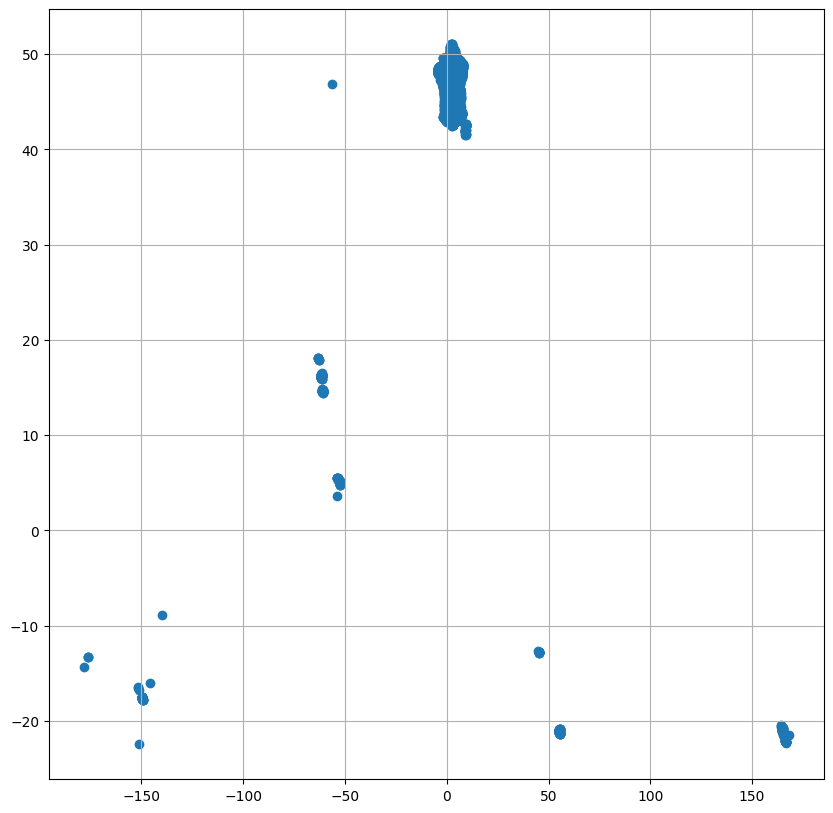

In [41]:
fig, ax = plt.subplots(figsize=(10,10))
ax.grid()
# Map of killed
killed=accid[accid['grav']==2]
ax.scatter(killed['long'],killed['lat'])

The cluster on top covers the Metropolitan region of France. The sparser points point to populated/city-like territories in France where accidents have been reported.

⏩ Let us zoom: complete the code

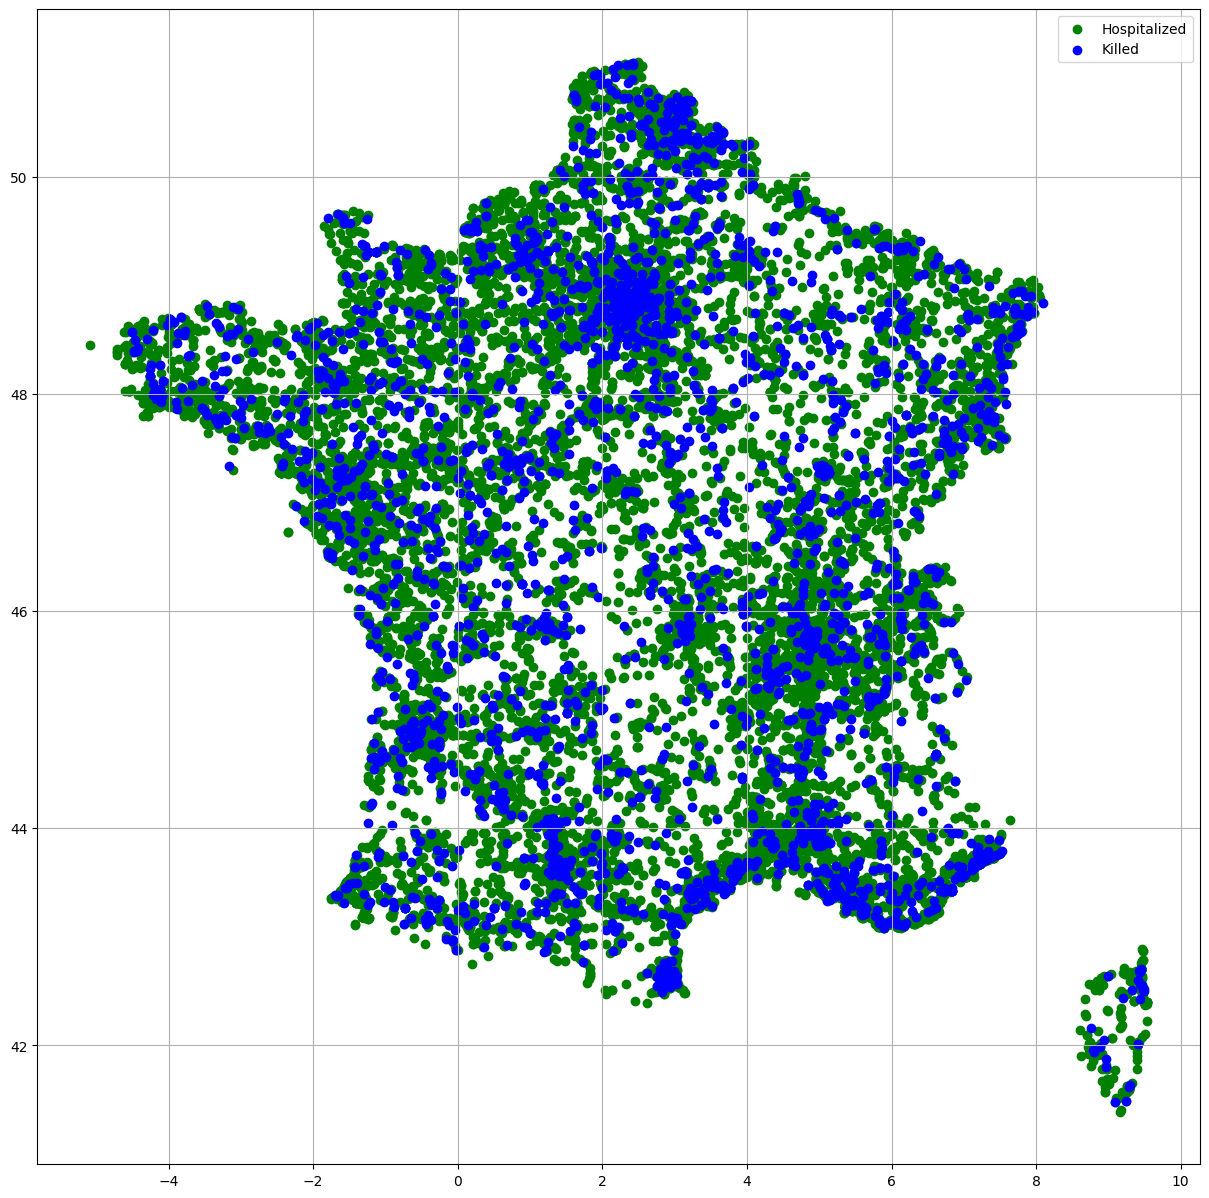

In [42]:
fig, ax = plt.subplots(figsize=(15,15))
ax.grid()

# Complete HERE
accid_met=accid[(accid['long'] >= -6 ) & (accid['lat'] >= 40)]

line1=ax.scatter(accid_met[accid_met['grav']==3]['long'],accid_met[accid_met['grav']==3]['lat'],color='green',label='Hospitalized')
line2=ax.scatter(accid_met[accid_met['grav']==2]['long'],accid_met[accid_met['grav']==2]['lat'],color='blue',label='Killed')
ax.legend(handles=[line1, line2])

⏩ How man people killed in 2021? What is the proportion of deadly accidents?

In [43]:
print(accid['grav'].value_counts())
print(accid['grav'].value_counts() / len(accid))

grav
 1    55108
 4    51681
 3    19085
 2     3219
-1       60
Name: count, dtype: int64
grav
 1    0.426688
 4    0.400153
 3    0.147770
 2    0.024924
-1    0.000465
Name: count, dtype: float64


Number of people killed in 2021: 3219

Proportion of deadly accidents: 0.024924

⏩ Comment the output of the cells below

In [44]:
print(accid['sexe'].value_counts())

sexe
 1    86196
 2    39895
-1     3062
Name: count, dtype: int64


Out of filled rows for the sex column, it appears that more number of males (86196) died compared to the number of females (39895).

In [45]:
print('Repartition of men casualties : \n', accid[accid['sexe']==1]['grav'].value_counts(), '\n')
print('Repartition of women casualties : \n', accid[accid['sexe']==2]['grav'].value_counts())

Repartition of men casualties : 
 grav
1    37163
4    32873
3    13640
2     2520
Name: count, dtype: int64 

Repartition of women casualties : 
 grav
4    18808
1    14943
3     5445
2      699
Name: count, dtype: int64


In each category of severity, more number of males were impacted when compared to the number of females (almost double for each category)

In [46]:
print('Accidents in built-up areas (2) and outside built-up areas (1) ; \n ',accid['agg'].value_counts(), '\n')
print('Repartition of accidents in built-up areas : \n', accid[accid['agg']==2]['grav'].value_counts(), '\n')
print('Repartition of accidents outside built-up areas : \n', accid[accid['agg']==1]['grav'].value_counts(), '\n')

Accidents in built-up areas (2) and outside built-up areas (1) ; 
  agg
2    80749
1    48404
Name: count, dtype: int64 

Repartition of accidents in built-up areas : 
 grav
 1    36526
 4    34024
 3     9079
 2     1067
-1       53
Name: count, dtype: int64 

Repartition of accidents outside built-up areas : 
 grav
 1    18582
 4    17657
 3    10006
 2     2152
-1        7
Name: count, dtype: int64 



In general, there are more number of accidents (almost double) in built-up areas when compared to outside build-up areas.

However, comparing each category of severity, we can see that there are more number of accidents that lead to death and hospitalization in outside built up areas compared to the built up areas. 

In the case of slightly injured and free categories, there are more number of accidents (almost double) in the built up areas.

### Formatting data for processing by the ML algorithm

Most features are categorical.
We will examine them one by one, possibly eliminating them, cleaning them up and categorizing them when necessary.
Some rules :
- If instances of a categorical feature are infrequent, they are combined into a single instance to avoid overfitting, otherwise the OneHot encoding will create too many new ones
unrepresentative columns,
- If the feature supposed to be numeric contains NaN, put them say at the average value of the numeric instances,
- If the digital feature contains an outlier, clip it,
- If "common sense" tells us that a feature is unlikely to have an impact on the performance of the algorithm, we eliminate it outright.

In [47]:
# First of all, let's identify the possible lines for which the severity of the accident is unknown
accid['grav'].value_counts()

grav
 1    55108
 4    51681
 3    19085
 2     3219
-1       60
Name: count, dtype: int64

We drop the 60 accident of unknown severity from the data set

In [48]:
# There are 60 accidents of unknown severity. We eliminate them.
accid.drop(accid[accid['grav'] == -1].index, inplace = True)

In [49]:
accid['grav'].value_counts()

grav
1    55108
4    51681
3    19085
2     3219
Name: count, dtype: int64

⏩ Create a new column named `severe`, whose value is equal to one if the accident has severity `grav` 2 (hospital) or 3 (killed), and zero otherwise.

In [50]:
accid['severe'] = accid['grav'].apply(lambda x:int(1 if x==2 or x==3 else 0))

⏩ What is the ratio of severe accidents among all accidents?

In [51]:
len(accid[accid['severe'] == 1])/len(accid)

0.1727746663258271

The ratio is 0.1727746663258271

⏩ We investigate the 'place' feature. Explain what the following code is doing.

In [52]:
print(accid['place'].value_counts())
pd.get_dummies(accid['place']).corrwith(accid['severe'])

place
1     96985
2     14452
10     9474
3      2474
4      2228
9      1187
7      1101
5       608
8       437
6       147
Name: count, dtype: int64


1    -0.055343
2    -0.002466
3    -0.022634
4    -0.023905
5    -0.007795
6    -0.002064
7     0.015102
8     0.005820
9     0.008784
10    0.111036
dtype: float64

The above code shows how number of accidents in each category of 'place' and finds the correlation between each category of 'place' with severity. The closer the correlation to -1 and 1, the  stronger the relationship is between place and severity.

Places -1, 6, 8 and 5 are not very representative and have little correlation with the severity of the accident. We will merge them into a single value, for example 20.

In [53]:
accid.place.replace([-1,6,8,5], 20,inplace=True)

/var/folders/hz/zdjmtw794kb0xp726t0svss40000gn/T/ipykernel_79129/3388156138.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  accid.place.replace([-1,6,8,5], 20,inplace=True)


In [54]:
print(accid['place'].value_counts())
pd.get_dummies(accid['place']).corrwith(accid['severe'])

place
1     96985
2     14452
10     9474
3      2474
4      2228
20     1192
9      1187
7      1101
Name: count, dtype: int64


1    -0.055343
2    -0.002466
3    -0.022634
4    -0.023905
7     0.015102
9     0.008784
10    0.111036
20   -0.002774
dtype: float64

⏩ Inspect the catu attribute (1=driver, 2=passenger, 3=pedestrian). Which of these values is the most correlated with the severity of the accident?

In [55]:
print(accid['catu'].value_counts())
pd.get_dummies(accid['catu']).corrwith(accid['severe'])

catu
1    97216
2    22403
3     9474
Name: count, dtype: int64


1   -0.055758
2   -0.012967
3    0.111036
dtype: float64

Catu=1 (driver) has a negative correlation of -0.055758.
Catu=2 (passenger) has a slightly negative correlation of -0.012967.
Catu=3 (pedestrian) has a positive correlation of 0.111036.

Therefore, from above, 'catu=3' (pedestrian) is the most positively correlated with the severity of the accident among these three categories, but it also has the smallest count which might affect it.

⏩ Inspect the 'trajet' column. What type of travel seems to be correlated with severe injuries?

In [56]:
print(accid['trajet'].value_counts())
pd.get_dummies(accid['trajet']).corrwith(accid['severe'])

trajet
 5    45423
 0    32549
 1    17337
 4    12181
 9    11031
 3     4531
-1     3210
 2     2831
Name: count, dtype: int64


-1   -0.069031
 0   -0.039289
 1   -0.020816
 2   -0.004075
 3    0.030191
 4   -0.088147
 5    0.131597
 9   -0.025498
dtype: float64

It seems that accidents involving leisure walks ('trajet=5') have the highest positive correlation with severe injuries with a high count as well.

⏩ Inspect the 'an_nais' column, which corresponds to the birth year. In case you find that there are missing values, do something appropriate.

In [57]:
accid['an_nais'].isnull().sum()

3007

There are 3007 missing values in total.

In [58]:
# YOUR CLEANING PROCEDURE HERE
anais_mean = accid['an_nais'].mean()
accid['an_nais'] = accid['an_nais'].fillna(anais_mean)

In [59]:
anais_mean

1983.095426930825

In [60]:
accid['an_nais'].isnull().sum()

0

We transform secu1, secu2 and secu3 => security equipment.

 There are three columns because a user can use up to three devices.

 We do a OneHot encoding "by hand"

In [61]:
accid['belt'] = accid[['secu1','secu2','secu3']].apply(lambda x:int((x[0]==1)|(x[1]==1)|(x[2]==1)),axis=1)
accid['helmet'] = accid[['secu1','secu2','secu3']].apply(lambda x:int((x[0]==2)|(x[1]==2)|(x[2]==2)),axis=1)
accid['child_equip'] = accid[['secu1','secu2','secu3']].apply(lambda x:int((x[0]==3)|(x[1]==3)|(x[2]==3)),axis=1)
accid['airbag'] = accid[['secu1','secu2','secu3']].apply(lambda x:int((x[0]==5)|(x[1]==5)|(x[2]==5)),axis=1)
accid['no_equip'] = accid[['secu1','secu2','secu3']].apply(lambda x:int((x[0]==0)&(x[1]==0)&(x[2]==0)),axis=1)


/var/folders/hz/zdjmtw794kb0xp726t0svss40000gn/T/ipykernel_79129/77793835.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  accid['belt'] = accid[['secu1','secu2','secu3']].apply(lambda x:int((x[0]==1)|(x[1]==1)|(x[2]==1)),axis=1)
/var/folders/hz/zdjmtw794kb0xp726t0svss40000gn/T/ipykernel_79129/77793835.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  accid['helmet'] = accid[['secu1','secu2','secu3']].apply(lambda x:int((x[0]==2)|(x[1]==2)|(x[2]==2)),axis=1)
/var/folders/hz/zdjmtw794kb0xp726t0svss40000gn/T/ipykernel_79129/77793835.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. 

⏩ Drop 'secu1','secu2','secu3' columns

In [62]:
accid.drop(columns=['secu1','secu2','secu3'],inplace=True)

In [63]:
accid

,Num_Acc,id_vehicule,place,catu,grav,sexe,an_nais,trajet,locp,actp,...,nbv,prof,surf,vma,severe,belt,helmet,child_equip,airbag,no_equip
0,202100000001,201 764,1,1,3,1,2000.0,1,0,0,...,2,1,1,80,1,0,0,0,0,0
1,202100000001,201 765,1,1,1,1,1978.0,1,0,0,...,2,1,1,80,0,1,0,0,0,0
2,202100000002,201 762,1,1,4,1,1983.0,0,0,0,...,2,1,1,80,0,1,0,0,0,0
3,202100000002,201 763,1,1,3,1,1993.0,0,0,0,...,2,1,1,80,1,1,0,0,0,0
4,202100000003,201 761,1,1,1,1,1995.0,1,0,0,...,2,1,1,50,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129148,202100056516,100 885,1,1,4,1,1975.0,0,0,0,...,2,2,2,80,0,1,0,0,0,0
129149,202100056516,100 886,1,1,4,1,2002.0,5,0,0,...,2,2,2,80,0,1,0,0,0,0
129150,202100056517,100 884,1,1,3,1,1999.0,0,0,0,...,2,1,2,80,1,0,0,0,0,0
129151,202100056518,100 882,1,1,3,1,1968.0,3,-1,-1,...,2,1,2,70,1,1,0,0,0,0


Inspect the vma columns, which corresponds to the maximal speed in km/h. Draw a boxplot of the column. Are some values absurd?

In [64]:
accid[['vma']].max()

vma    901
dtype: int64

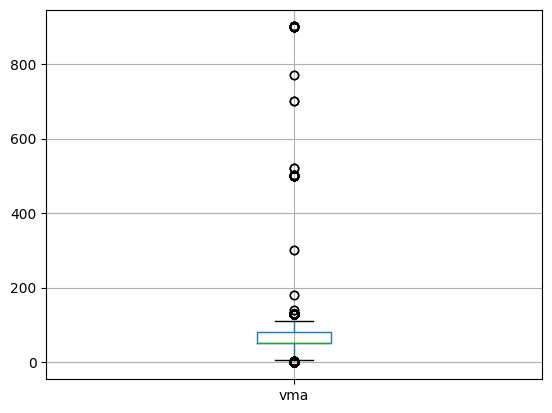

In [65]:
boxplot = accid[['vma']].boxplot()

Maximal speed of the boxplot's range: about 110-130 km/h
Minimal speed: 0 km/h


Some values such as speeds beyond 400 km/h seem absurd and should be trimmed off.

⏩ What is the following code doing?

In [66]:
accid['vma_clipped'] = accid['vma'].clip(lower = 0, upper = 130)

<Axes: >

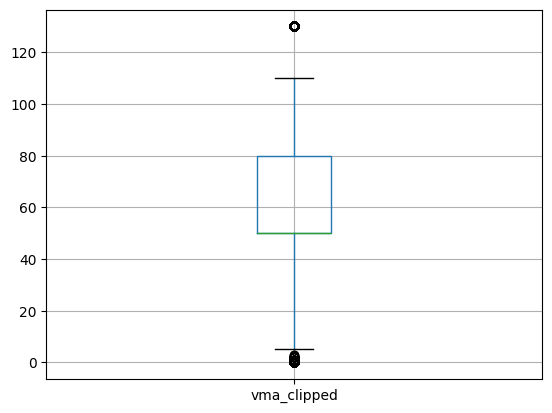

In [67]:
accid[['vma_clipped']].boxplot()

The absurd values/outliers have been trimmed off so that they don't negatively impact our training model later on.

# PART 2. Binary Classification
We propose to keep the following columns. Note that there are many columns for which we did not use any feature engineering or cleansing, feel free to do it in order to improve the results!

In [68]:
columns_to_keep = ['place', 'catu', 'sexe', 'an_nais',
       'trajet', 'lum', 'agg','surf',
       'atm',  'belt', 'helmet', 'child_equip', 'airbag', 'no_equip',
       'vma_clipped','locp',  'etatp', 'catv', 'obs', 'obsm', 'motor', 'int','catr', 'circ', 'nbv', 'prof']
accid[columns_to_keep].info()

<class 'pandas.core.frame.DataFrame'>
Index: 129093 entries, 0 to 129152
Data columns (total 26 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   place        129093 non-null  int64  
 1   catu         129093 non-null  int64  
 2   sexe         129093 non-null  int64  
 3   an_nais      129093 non-null  float64
 4   trajet       129093 non-null  int64  
 5   lum          129093 non-null  int64  
 6   agg          129093 non-null  int64  
 7   surf         129093 non-null  int64  
 8   atm          129093 non-null  int64  
 9   belt         129093 non-null  int64  
 10  helmet       129093 non-null  int64  
 11  child_equip  129093 non-null  int64  
 12  airbag       129093 non-null  int64  
 13  no_equip     129093 non-null  int64  
 14  vma_clipped  129093 non-null  int64  
 15  locp         129093 non-null  int64  
 16  etatp        129093 non-null  int64  
 17  catv         129093 non-null  int64  
 18  obs          129093 non-null 

⏩ Perform the train-test split, keeping only the above `columns_to_keep` list

So far, we are only interested in binary classification, so the label column would be `accid['severe']`. However, we will later be interested in multiclass classification. Therefore, you can have two label columns `accid[['severe','grav']]`

In [69]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(accid[columns_to_keep], accid[['severe','grav']],train_size=0.66)

⏩ Run the next cell. If one had to use onehot encoding, how many columns would we have?

In [70]:
x_train.nunique()

place            8
catu             3
sexe             3
an_nais        103
trajet           8
lum              5
agg              2
surf            10
atm             10
belt             2
helmet           2
child_equip      2
airbag           2
no_equip         2
vma_clipped     26
locp            11
etatp            4
catv            32
obs             19
obsm             8
motor            8
int              9
catr             8
circ             5
nbv             14
prof             5
dtype: int64

In [73]:
x_train.nunique().sum()

311

If we used one hot encoding, we would have 311 columns since that's the total number of unique values in our dataframe.

Running value_counts() on some columns, we observe that some values are quite rare. They bring complexity into the model, but little information to learn from. It might be wise to merge rare values into a single "bin". We do not handle this here, but you may try this at home if you wish.

In [74]:
x_train['surf'].value_counts()

surf
 1    68849
 2    15079
 7      406
 9      334
 5      238
 3      104
 8       85
 6       51
 4       38
-1       17
Name: count, dtype: int64

## Decision tree
⏩ Train a decision tree, using the default parameters.

In [75]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(x_train, y_train['severe'])

DecisionTreeClassifier()

⏩ Compute the accuracy score. You should find something around 80% of correct predictions. Not bad for a decision tree?

In [76]:
from sklearn.metrics import accuracy_score
accuracy_score(dt.predict(x_test), y_test.severe)

0.790098423402898

⏩ Compare the accuracy of the classifier which outputs "0" for every input, and explain.

In [77]:
accuracy_score(np.zeros(len(y_test.severe)), y_test.severe)

0.8283741911965734

The classifier here predicts "0" for every input, effectively treating all instances as the negative class. A high accuracy score of 82% shows that the data set is imbalanced with the "0" class being more prevelant in the dataset.

⏩ Compute the area under the ROC curve for the decision tree

In [80]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test.severe, dt.predict_proba(x_test)[:,1])

0.6522022701861034

## Random Forest
⏩ Train a random forest classifier, using the default parameters.

Provide the accuracy score and the AUC.


In [81]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(x_train, y_train['severe'])

RandomForestClassifier()

In [82]:
from sklearn.metrics import accuracy_score
accuracy_score(rf.predict(x_test), y_test.severe)

0.8486968012394058

In [83]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test.severe, rf.predict_proba(x_test)[:,1])

0.8408261129691222

⏩ Now set `min_samples_split` to a higher value than the default value 2. Compare the performance, and explain.



In [54]:
from sklearn.ensemble import RandomForestClassifier
rf_2 = RandomForestClassifier(min_samples_split=16)
rf_2.fit(x_train, y_train['severe'])

RandomForestClassifier(min_samples_split=16)

In [55]:
from sklearn.metrics import accuracy_score
accuracy_score(rf_2.predict(x_test), y_test.severe)

0.8548710471156475

In [56]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test.severe, rf_2.predict_proba(x_test)[:,1])

0.8539174115975836

Increasing the min_samples_split means that we are including more nodes of trees and make it more generalizable. Since random forests tend to overfit very frequently as we learnt in class, larger values for min_samples_split can help prevent overfitting by making the trees less sensitive to noise and specific patterns in the training data. This may lead to a model that generalizes better to new, unseen data. Hence, the accuracy score is better by about 1% when compared to the one with 2 min_sample_splits.


⏩ What does the `n_estimators` parameter refers to? What is the default value? You may try to play with this parameter if time permits.

In [84]:
from sklearn.ensemble import RandomForestClassifier
rf_3 = RandomForestClassifier(n_estimators=800)
rf_3.fit(x_train, y_train['severe'])

RandomForestClassifier(n_estimators=800)

In [85]:
from sklearn.metrics import accuracy_score
accuracy_score(rf_3.predict(x_test), y_test.severe)

0.8500410097512076

In [86]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test.severe, rf_3.predict_proba(x_test)[:,1])

0.8447802468171919

The n_estimators parameter in the RandomForestClassifier is the number of decision trees used in the random forest. Each decision tree in the forest is trained independently, and the final prediction is typically made by aggregating the predictions of all individual trees.

The default value here is 100.

Increasing n_estimators generally improves the model's performance by reducing overfitting. But, it also comes with a computational cost.

⏩ Explain what `rf.feature_importances_` refers to. Plot bars of feature importances. Comment the result.

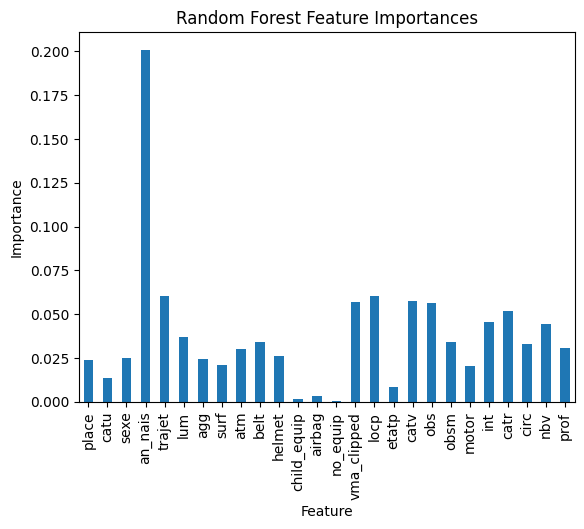

In [87]:
rf_importances = pd.Series(rf.feature_importances_, index=columns_to_keep)
rf_importances.plot.bar()
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Random Forest Feature Importances')
plt.show()
# n.b. One should treat this information with caution.
# Indeed, numerical attributes tend to be more often chosen as a split, because they are harder to learn than, for instance, binary attributes.
# As a consequence, they may naturally end up with a higher feature importance

The rf.feature_importances_ attribute in scikit-learn's RandomForestClassifier represents the importance of each feature in making predictions. Feature importance is a measure of how much each feature contributes to the overall decision-making process of the random forest model.

Here, an_nais has a very high importance, but that column is treated as a continuous column of numerical features that aren't as easy to learn in comparison to simpler categories of binary attributes. We must therefore be careful about it.
Features with higher importance such as an_nais, trajet, locp, vma, catv, etc. are more influential in making predictions. 


## XGBoost
⏩ Train a XGBoost classifier, using the default parameters.

Provide the accuracy score and the AUC.

Try to change the `learning_rate` and `n_estimators` parameters

In [88]:
# !pip install xgboost
import xgboost
from xgboost import XGBClassifier

In [89]:
xg = XGBClassifier()
xg.fit(x_train, y_train['severe'])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [90]:
from sklearn.metrics import accuracy_score
accuracy_score(xg.predict(x_test), y_test.severe)

0.8567164859199854

In [91]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test.severe, xg.predict_proba(x_test)[:,1])

0.8586200000688591

Trying learning rate of 0.2

In [92]:
import xgboost
from xgboost import XGBClassifier
xg_2 = XGBClassifier(learning_rate=0.2)
xg_2.fit(x_train, y_train['severe'])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [93]:
from sklearn.metrics import accuracy_score
accuracy_score(xg_2.predict(x_test), y_test.severe)

0.8572632826027522

In [94]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test.severe, xg_2.predict_proba(x_test)[:,1])

0.8597659904677803

Trying out learning rate of 0.0001

In [95]:
import xgboost
from xgboost import XGBClassifier
xg_3 = XGBClassifier(learning_rate=0.0001)
xg_3.fit(x_train, y_train['severe'])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.0001, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [96]:
from sklearn.metrics import accuracy_score
accuracy_score(xg_3.predict(x_test), y_test.severe)

0.8283741911965734

In [97]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test.severe, xg_3.predict_proba(x_test)[:,1])

0.8245619637557818

Higher learning rate here represented higher accuracy scores for XGBoost

Trying 180 n_estimators

In [98]:
import xgboost
from xgboost import XGBClassifier
xg_4 = XGBClassifier(n_estimators=180)
xg_4.fit(x_train, y_train['severe'])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=180, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [99]:
from sklearn.metrics import accuracy_score
accuracy_score(xg_4.predict(x_test), y_test.severe)

0.8544609496035724

In [100]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test.severe, xg_4.predict_proba(x_test)[:,1])

0.8559554166732524

## Logistic regression

We now compare the result to logistic regression. To this end, we first need to onehot encode all categorical columns. We use sklearn onehotencoder.

⏩ Fill the code below

In [101]:
from sklearn.preprocessing import OneHotEncoder

categorical_features = ['place', 'catu', 'sexe',
       'trajet', 'lum', 'agg','surf',
       'atm',  'belt', 'helmet', 'child_equip', 'airbag', 'no_equip',
       'locp',  'etatp', 'catv', 'obs', 'obsm', 'motor', 'int','catr', 'circ', 'nbv', 'prof']

ec = OneHotEncoder()

dummy_cols = ec.fit_transform(x_train[categorical_features])

⏩ What is the type of `dummy_cols`? What is the interest of using this type?

In [106]:
type(dummy_cols)

scipy.sparse._csr.csr_matrix

The type is 'scipy.sparse.csr.csr_matrix.' This type represents a sparse matrix in the Compressed Sparse Row (CSR) format. One-hot encoding often results in a matrix with many zero entries, especially when dealing with categorical features with a large number of unique values. Sparse matrices efficiently store and manipulate such data by only storing non-zero values and their positions. When dealing with large datasets such as ours, using sparse matrices can significantly reduce the memory requirements compared to using dense matrices. 

In [107]:
dummy_cols.data.nbytes/dummy_cols.toarray().data.nbytes

0.13186813186813187

Above expression calculates the ratio of the memory usage between the original sparse matrix (dummy_cols) and its dense counterpart obtained by converting it to a NumPy array (dummy_cols.toarray()). This ratio provides insights into the memory efficiency of using a sparse matrix and clearly shows how less of the mmeory is occupied by a sparse matrix in comparison.

In this example, not all the attributes are categorical. We use ColumnTransformer in order to onehotencode the categorical columns, and leave the remaining columns unchanged.

In [108]:
from sklearn.compose import ColumnTransformer
transformer=ColumnTransformer( transformers=[('OneHot',OneHotEncoder(handle_unknown='ignore'),categorical_features)],remainder="passthrough")
x_train_oh = transformer.fit_transform(x_train)

We print the first line: notice the dummy variables and the numerical variable at the end.

In [109]:
x_train_oh.toarray()[0]

array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
       1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
       1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
       0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 

⏩ How many rows/colums does x_train_oh contains?

In [110]:
x_train_oh.shape

(85201, 184)

Some columns have only a small number of ones. Here, we decide to delete these columns before training/ Of course, smarter approaches could be used (more detailed EDA, Lasso, etc.)

In [111]:
number_of_ones = sum(x_train_oh).toarray()

In [112]:
cols = [ i for i in range (184) if number_of_ones[0][i]>200]
x_train_lr = x_train_oh[:,cols]

The threshold to keep 1s here is 200.

⏩ Fit a logistic regression

In [113]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(x_train_lr, y_train['severe'])

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

We transform x_test similarly to x_train, using the previous ColumnTransformer

In [114]:
x_test_oh = transformer.transform(x_test)
x_test_lr = x_test_oh[:,cols]

⏩ Provide the accuracy and the AUC of the logistic regression

In [115]:
from sklearn.metrics import accuracy_score
accuracy_score(lr.predict(x_test_lr), y_test.severe)

0.8488562836052128

In [119]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test.severe, lr.predict_proba(x_test_lr)[:,1])

0.827878540542062

# PART 3. Multiclass classification

We now would like to predict the class (1,2,3,4) in the `grav` label). Recall that 1=free, 2=killed, 3=severe_injury, 4=slight_injury

⏩ Fit a `LogisticRegression` classifier using the argument `multi_class='multinomial'`. What is the name of the loss function used by this classifier?

In [122]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(multi_class='multinomial')
lr.fit(x_train_lr, y_train['grav'])

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(multi_class='multinomial')

The loss function used is 'cross-entropy' or 'soft-max log loss'

The next cells give an example of the output classifier, in terms of scores and hard decisions

In [124]:
print("Output probabilities of the 0th test input: ",lr.predict_proba(x_test_lr[0]))
print("Hard decision of the 0th test input: ", lr.predict(x_test_lr[0]), "... that is the argument of the maximum probability")

Output probabilities of the 0th test input:  [[0.75143799 0.01634551 0.09686741 0.13534909]]
Hard decision of the 0th test input:  [1] ... that is the argument of the maximum probability


1 has the highest output probability in comparison and is hard decided as "1" for the 0th input.

⏩ Print the confusion matrix, and provide your comment about its structure. Explain.

In [125]:
from sklearn.metrics import confusion_matrix
confusion_matrix(lr.predict(x_test_lr),y_test.grav)

array([[14803,   293,  1588,  6773],
       [    0,     0,     0,     0],
       [  306,   264,   999,   520],
       [ 3567,   548,  3841, 10390]])

Class 2 (Killed): The confusion matrix shows all zeros for '2,' suggesting that the model did not predict any instances for this class, and there are no true instances in the test set.

Imbalanced Classes: The class distribution seems imbalanced, especially for '1' and '4.'

Diagonal Elements (True Positives): The diagonal elements represent the number of correctly classified instances for each class (True Positives). 

Off-Diagonal Elements: Off-diagonal elements represent misclassifications (False Positives and False Negatives) for each class. Analyzing these elements provides insights into the specific types of errors the model is making.

Overall Interpretation: The confusion matrix is a valuable tool for assessing model performance, identifying areas of improvement, and understanding the distribution of errors across classes.

⏩ Re-train a logistic classifier, but now use the argument `class_weight='balanced'`. Observe the confusion matrix. Explain.

In [139]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(class_weight='balanced')
lr.fit(x_train_lr, y_train['grav'])

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced')

[[13722   115   750  5052]
 [ 1378   597  2226  2282]
 [ 1405   266  2091  2984]
 [ 2171   127  1361  7365]]


<Axes: >

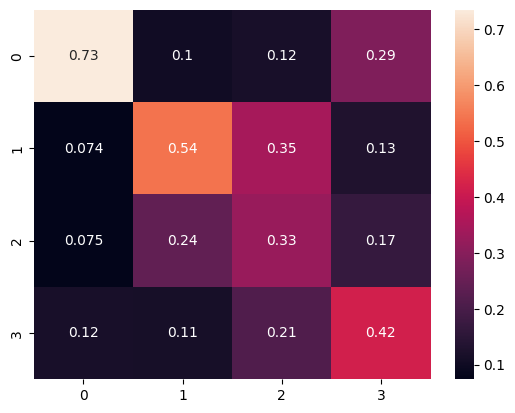

In [140]:
# We normalize the confusion matrix in such a way that every column has a sum equal to one
confmat = confusion_matrix(lr.predict(x_test_lr),y_test.grav)
print(confmat)
confusion_probabilities = confmat / sum(confmat)
sns.heatmap(confusion_probabilities,annot=True)


Balanced Class Weights: By using class_weight='balanced', the model automatically adjusts the weights during training to account for class imbalances.

Class 2 (Killed): The model now predicts instances for '2,' and there are True Positives and False Positives for this class. This suggests that the balanced class weights have allowed the model to better handle the minority class.

The model with balanced class weights appears to have improved sensitivity for some classes, as indicated by increased True Positives.

The heatmap lets us visualize the confusion matrix better.


⏩ Train a random forest (using `class_weight='balanced'`) and plot the (normalized) confusion matrix

In [128]:
from sklearn.ensemble import RandomForestClassifier
rff = RandomForestClassifier(class_weight='balanced')
rff.fit(x_train, y_train['grav'])

RandomForestClassifier(class_weight='balanced')

[[14517   205   998  4562]
 [   45    67   117    57]
 [  624   449  2362  1609]
 [ 3490   384  2951 11455]]


<Axes: >

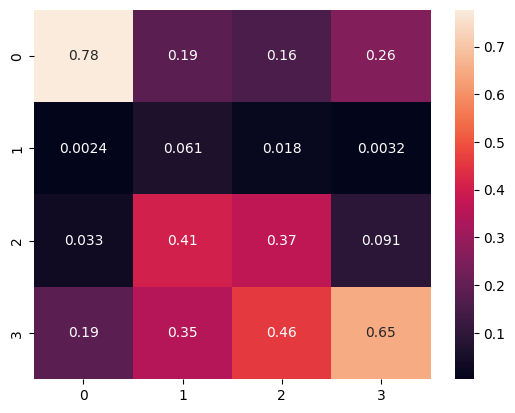

In [130]:
confmat = confusion_matrix(rff.predict(x_test),y_test.grav)
print(confmat)
confusion_probabilities = confmat / sum(confmat)
sns.heatmap(confusion_probabilities,annot=True)

The RandomForestClassifier with the balanced class weights is working well for true positives, especially for '0,' '1,' and '3' but for '2' the values are still not very balanced and has less true positives compared to the one by logistic regression.

In order to compare the performance of two classifiers using a single measure, one option is to compute the log_loss, or cross entropy loss [see here](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_loss_function_and_logistic_regression)

To this end we first need, to format the label column using a `LabelBinarizer`


In [141]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
lb.fit(y_train.grav)

LabelBinarizer()

In [142]:
# Here is what the LabelBinarizer output looks like
lb.transform(y_test.grav)

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       ...,
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0]])

In [143]:
# To be compared with the output probability scores
rff.predict_proba(x_test)

array([[0.81      , 0.        , 0.01      , 0.18      ],
       [0.33      , 0.        , 0.06      , 0.61      ],
       [0.99      , 0.        , 0.        , 0.01      ],
       ...,
       [0.41933005, 0.00945156, 0.08      , 0.49121838],
       [0.05      , 0.02      , 0.34      , 0.59      ],
       [0.88      , 0.        , 0.        , 0.12      ]])

⏩ Compare the log_loss of random forest to logistic regression, and to XGBoost.

In [146]:
from sklearn.metrics import log_loss
log_loss(y_test.grav, lr.predict_proba(x_test_lr))

1.0729810917189828

In [148]:
from sklearn.metrics import log_loss
log_loss(y_test.grav, rff.predict_proba(x_test))

1.0493900904674436

In [153]:
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight


y_train_mapped = y_train['grav'] - 1  
y_test_mapped = y_test['grav'] - 1    


class_weights = compute_sample_weight('balanced', y_train_mapped)


xg = XGBClassifier()


xg.fit(x_train, y_train_mapped, sample_weight=class_weights)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [155]:
from sklearn.metrics import log_loss
log_loss(y_test.grav, xg.predict_proba(x_test))

0.8964893315900193

In comparison, the order of log loss is: logistic regression > random forests > xgboost. 
XGBoost exhibits the lowest log loss, suggesting that it provides more accurate probability predictions compared to the other two models

# Conclusion

In this notebook, we have seen how to

*   Perform an EDA (although more could have been done)
*   Clean up a data set
*   Use random forest and XGBoost
*   Use sklearn onehotencoder, columnencoder
*   Handle mutliclass classification using log_loss, confusion matrices
*   Deal with unbalanced data sets

